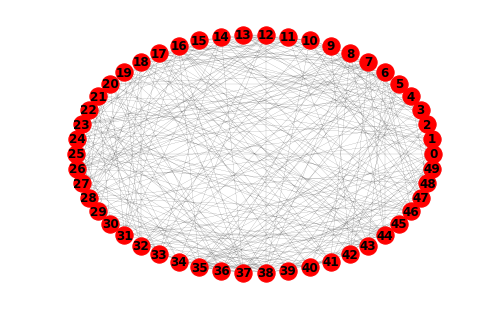

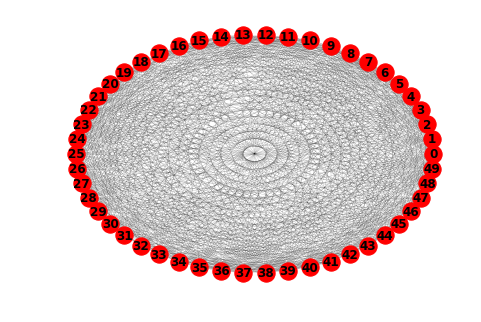

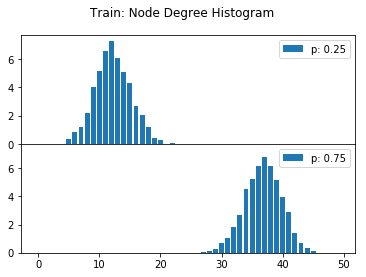

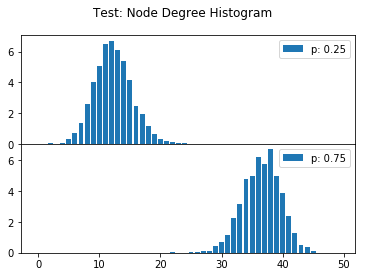

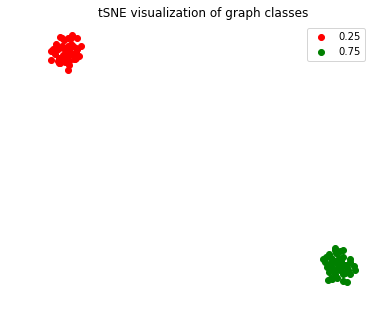

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import networkx.algorithms.approximation.clustering_coefficient as cc
import networkx.algorithms.shortest_paths.generic as sp
from sklearn.manifold import TSNE
# from node2vec import Node2Vec
import math
import pdb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def pad_zeros(input_vector, output_size):
    pad = np.zeros(output_size - input_vector.shape[0])
    return np.append(input_vector, pad)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def graph_to_degree_hist(graph):
    degree_hist = np.array(nx.degree_histogram(graph))
    degree_hist_padded = pad_zeros(degree_hist, num_nodes)
    return degree_hist_padded

def generate_graph(num_nodes, p, k=None, m=None, gamma=3, graph_type=1):
    if graph_type == 1:
        G = nx.fast_gnp_random_graph(n=num_nodes, p=prob)
    elif graph_type == 2:
        G = nx.watts_strogatz_graph(n=num_nodes, k=k, p=prob)
    elif graph_type == 3:
        G = nx.newman_watts_strogatz_graph(n=num_nodes, k=k, p=prob)
    elif graph_type == 4:
        G = nx.connected_watts_strogatz_graph(n=num_nodes, k=k, p=prob)
    elif graph_type == 5:
        G = nx.barabasi_albert_graph(n=num_nodes, m=m)
    elif graph_type == 6:
        G = nx.powerlaw_cluster_graph(n=num_nodes, m=m, p=prob)
    elif graph_type == 7:
        G = nx.random_powerlaw_tree(n=num_nodes, gamma=gamma)
    return G

def plot_degree_histograms(data, labels, prefix=""):
    classes = sorted(list(set(labels)))
    num_classes = len(classes)
    labels = np.array(labels)
    
    f, axarr = plt.subplots(num_classes, sharex=True, sharey=True)
    f.suptitle("{}: Node Degree Histogram".format(prefix))
    
    for counter, class_category in enumerate(classes):
        idx = np.where(labels == class_category)
        X = data[idx]
        mean_hist = np.mean(np.array(X), axis=0)
        axarr[counter].bar(np.arange(data.shape[1]), mean_hist, label="p: "+class_category)
        
    f.subplots_adjust(hspace=0)
    for ax in axarr:
        ax.label_outer()
        ax.legend()
        
def tSNE_visualization(data, labels):
    tsne = TSNE(n_components=2, random_state=0)
    data_2d = tsne.fit_transform(data)
    label_classes = np.unique(labels).tolist()
    
    plt.figure(figsize=(6, 5))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
    for i, c in zip(label_classes, colors):
        plt.scatter(data_2d[labels == i, 0], data_2d[labels == i, 1], c=c, label=i)
    plt.title("tSNE visualization of graph classes")
    plt.legend()

probability_tests = {
    "test1": [0.25, 0.75],
    "test2": [0.49999, 0.50001],
    "test3": [0.495, 0.505],
    "test4": [0.40, 0.45, 0.50, 0.55],
    "test5": [0.48, 0.49, 0.50, 0.51],
    "test6": [0.0, 0.5, 1.0],
    "test7": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "test8": [0.45, 0.55],
}

graph_types = {
    "fast_gnp_random_graph": 1,
    "watts_strogatz_graph": 2, # rewires existing edge with prob p
    "newman_watts_strogatz_graph": 3, # adds new edge with prob p
    "connected_watts_strogatz_graph": 4, # rewires existing edge with prob p, but ensures connected graph
    "barabasi_albert_graph": 5, # a graph of n nodes is grown by attaching new nodes each with m edges that are preferentially attached to existing nodes with high degree
    "powerlaw_cluster_graph": 6, # growing graphs with powerlaw degree distribution and approximate average clustering
    "random_powerlaw_tree": 7 # returns a tree with a power law degree distribution
}

# select probabilities test case
probs = probability_tests["test1"]

# select graph hyper-parameters
graph_type = graph_types["fast_gnp_random_graph"]
graphs_per_class = 50
num_nodes = 50 #569 in the Nature study
knn = 10 # used in watts-strogatz graphs
m_edges = 10 # used in barabasi-albert graph
gamma = 3 # used in random powerlaw tree

# plot specs
graph_edge_width = 0.1

graphs_train = []
graphs_test = []
labels_train = []
labels_test = []

# generate training and test graphs
for counter, prob in enumerate(probs):
    for graph in range(graphs_per_class):
        G_train = generate_graph(num_nodes, prob, knn, m_edges, gamma, graph_type=graph_type)
        G_test = generate_graph(num_nodes, prob, knn, m_edges, gamma, graph_type=graph_type)
        graphs_train.append(G_train)
        graphs_test.append(G_test)
        labels_train.append(str(prob))
        labels_test.append(str(prob))
    plt.figure(counter)
    nx.draw_circular(G_train, with_labels=True, font_weight='bold', width=graph_edge_width)
    # nx.draw_spring(G_train, with_labels=True, font_weight='bold', width=graph_edge_width)
    # print("rewiring probability: {} | cc: {} | sp {}".format(prob, cc.average_clustering(G_train),
    #                                                         sp.average_shortest_path_length(G_train)))
    
# feature engineering - node degree
X_train = []
X_test = []
for graph in graphs_train:
    hist_train = graph_to_degree_hist(graph)
    X_train.append(hist_train)
    
for graph in graphs_test:
    hist_test = graph_to_degree_hist(graph)
    X_test.append(hist_test)
    
train_X = np.array(X_train).reshape(-1, num_nodes) # number of features
test_X = np.array(X_test).reshape(-1, num_nodes) # number of features
train_labels = np.array(labels_train)
test_labels = np.array(labels_test)

plot_degree_histograms(train_X, train_labels, "Train")
plot_degree_histograms(test_X, test_labels, "Test")
tSNE_visualization(train_X, train_labels)

train_X, train_labels = unison_shuffled_copies(train_X, train_labels)
test_X, test_labels = unison_shuffled_copies(test_X, test_labels)

In [2]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

def print_results(predictions, labels, name):
    print("{}: {}".format(name, (predictions == labels).sum() / float(len(labels))))

# PCA
pca = PCA(n_components=0.99)
train_X_pca = pca.fit_transform(train_X)
test_X_pca = pca.transform(test_X)

classifiers = {
    "svm": SVC(C=1, kernel='rbf'),
    "random_forest": RandomForestClassifier(),
    "knn": KNeighborsClassifier(n_neighbors=20),
    "gnb": GaussianNB(),
    "dummy": DummyClassifier()
}

clf = classifiers["svm"]

# Training session 1
print(">>> no PCA")
clf.fit(train_X, train_labels)
train_predictions = clf.predict(train_X).reshape(-1,1)
test_predictions = clf.predict(test_X).reshape(-1,1)
print_results(np.ravel(train_predictions), train_labels, "Train Accuracy")
print_results(np.ravel(test_predictions), test_labels, "Test Accuracy")

# Training session 2
print("\n>>> no PCA - log degree")
clf.fit(np.log(train_X+1), train_labels)
train_predictions = clf.predict(np.log(train_X+1)).reshape(-1,1)
test_predictions = clf.predict(np.log(test_X+1)).reshape(-1,1)
print_results(np.ravel(train_predictions), train_labels, "Train Accuracy")
print_results(np.ravel(test_predictions), test_labels, "Test Accuracy")

# Training session 3
print("\n>>> PCA with 99% variance retained")
clf.fit(train_X_pca, train_labels)
train_predictions = clf.predict(train_X_pca).reshape(-1,1)
test_predictions = clf.predict(test_X_pca).reshape(-1,1)
print_results(np.ravel(train_predictions), train_labels, "Train Accuracy")
print_results(np.ravel(test_predictions), test_labels, "Test Accuracy")

>>> no PCA
Train Accuracy: 0.95
Test Accuracy: 0.91

>>> no PCA - log degree
Train Accuracy: 0.93
Test Accuracy: 0.92

>>> PCA with 99% variance retained
Train Accuracy: 0.99
Test Accuracy: 0.83
